# RCFM Model

## 1. Import modules and helper functions

In [1]:
# Modules
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.optimize import curve_fit
from scipy.stats import norm, probplot

# Helper functions from DataAid.py and DataImport.py
import DataAid
import DataImporter

# New v1v2 functions
import Neros

## 2. Load Galaxy Data

In [2]:
# Load Galaxy Data
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
sparc128Galaxies = DataAid.GetGalaxyData("data/Sparc/SparcSubset135/")
sparcTset = DataAid.GetGalaxyData("data/Sparc/TrainingSet/")
littleDataGalaxies = DataAid.GetGalaxyData("data/little-data-things/data/")
lcmGalaxies = DataAid.GetGalaxyData("data/LCMFits/data/")

# Load Milky Way Model Data
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
mcGaughMW = DataAid.GetGalaxyData("data/McGaugh/")

# Create array of Milky Way radius and vlum tuples from model data
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])
MWMcGaugh = np.array(mcGaughMW['MW_lumMcGaugh'])


## 3. Create Neros class instance

In [3]:
# Create Neros instance to perform calculations with the supplied Milky Way model as comparison
# Change Milky Way model by changing the variable in the parentheses
# i.e. neros_fns = Neros.Neros(MWModelVariable)

neros_fns = Neros.Neros(MWXueSofue)
#neros_fns = Neros.Neros(MWMcGaugh)
MW_name = "MWXueSofue" # Change this if you change the MW model in neros_fns!
#MW_name = "MWMcGaugh" # Change this if you change the MW model in neros_fns!
MW_rad = neros_fns.mw_rad
MW_vLum = neros_fns.mw_vLum
MW_vLum_interp_func = neros_fns.mw_vLum_interp

# Designate v1 and v2 functions used in model. 
# For filenaming and bookkeeping
v1='sinh' 
v2='cosh'

## 4. Designate galaxy sample

In [4]:
# This designates which galaxy sample to fit
galaxies = sparc128Galaxies

# remove outlier galaxies
# MWXueSofue
# delgal = galaxies.pop('UGC02953_rotmod-Copy1')
# delgal2 = galaxies.pop('UGC09133_rotmod-Copy1')


## 5. Fit galaxies, print and save graphs

In [5]:
def processGalaxy(galaxyData, plot=False):
    galaxy = np.array(galaxyData)
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    
    # Just fit then extract the relevant pieces
    neros_fns.fit(galaxy_rad, galaxy_gas, galaxy_disk, galaxy_bulge, galaxy_vObs, galaxy_error)
    fit_results = neros_fns.get_fit_results(galaxy_rad)
    
#     f, ax = plt.subplots(2,2, figsize=(12,12))
    
    trimmed_rad = neros_fns.get_rad()
    trimmed_vLum_updated = neros_fns.get_vLum_scaled()
    trimmed_vObs = neros_fns.get_vObs()
    trimmed_error = neros_fns.get_vObsError()
    vNeros = neros_fns.get_vNeros()
    # gbar = v_lum^2/R (luminous, composed of v_gas, v_disk, and v_bulge)
    # gobs = v_obs^2/R (observed)
    # gNeros = vNeros^2/R (model)
    log_gbar = np.log10(trimmed_vLum_updated**2/trimmed_rad)
    log_gobs = np.log10(trimmed_vObs**2/trimmed_rad)
    log_gneros = np.log10(vNeros**2/trimmed_rad)
    
    ordered_for_plot = sorted(zip(log_gbar, log_gneros))
    
    if plot:
        # Make plots of fits and difference of fit from data for each galaxy 
        # (false by default because it's a lot of graphs)
        
        # y-axis scales to the maximum velocity value in the list galaxy_vObs_err_incl
        # or to the maximum value in the list vNeros, whichever is the bigger number
        y_max = max(max(trimmed_vObs + trimmed_error), max(vNeros))
        ax[0,0].set_ylim(bottom = 0, top = y_max + 15)

        # plot vObs and vNeros and updated vLum
        ax[0,0].plot(trimmed_rad, trimmed_vObs, label="{}_vObs".format(galaxyName))
        ax[0,0].plot(trimmed_rad, vNeros, label="{}_vNeros".format(galaxyName))
        ax[0,0].plot(trimmed_rad, trimmed_vLum_updated, label="{}_new_vLum".format(galaxyName))
        ax[0,0].plot([],[], ' ', label="$\chi^2$ = {}".format(fit_results['chi_squared']))

        # error bar in vObs
        for i in range(len(trimmed_rad)):
            ax[0,0].vlines(trimmed_rad[i], trimmed_vObs[i] - trimmed_error[i], trimmed_vObs[i] + trimmed_error[i])

        ax[0,0].legend()
        ax[0,0].set_xlabel('Galaxy Radius (kpc)')
        ax[0,0].set_ylabel('Velocities (km/s)')

        ax[0,1].plot(trimmed_rad, trimmed_vObs - vNeros, 'ko')
        ax[0,1].set_xlabel('Galaxy Radius (kpc)')
        ax[0,1].set_ylabel('vObs - vNeros (km/s)')

        ax[1,1].plot(trimmed_vObs, vNeros, 'ko')
        ax[1,1].set_xlabel('vObs (km/s)')
        ax[1,1].set_ylabel('vNeros (km/s)')



        ax[1,0].scatter(log_gbar, log_gobs, label='data')
        ax[1,0].plot([x[0] for x in ordered_for_plot], [x[1] for x in ordered_for_plot], 'k-',label='Neros')
        ax[1,0].set_xlabel('gbar log10(km/s)')
        ax[1,0].set_ylabel('gobs log10(km/s)')
        ax[1,0].legend()
        plt.title()
        plt.close()
        plt.show()

    return (trimmed_vObs, vNeros, trimmed_rad, trimmed_vLum_updated)

# processGalaxy(galaxy)

In [6]:
all_obs = [] # vObs (observed rotation curve)
all_neros = [] # vNeros (model fit)
all_rad = [] # radii
all_vlum = [] # vlum (composed of disk, bulge, gas)
norm_obs = [] # (vObs-mean_vObs/std_vObs)
norm_neros = [] # (vNeros-mean_Neros/std_Neros)
gal = []
i = 0
for galaxyName in list(galaxies.keys()):
    try:
        galaxyData = galaxies[galaxyName]
        obs, neros, rad, vlum = processGalaxy(galaxyData)
        all_obs.extend(obs)
        all_neros.extend(neros)
        all_rad.extend(rad)
        all_vlum.extend(vlum)
        mean = np.mean(obs)
        std = np.std(obs)
        norm_obs.extend((obs - mean)/std)
        norm_neros.extend((neros - mean)/std)
        gal.extend([i]*len(obs))
        i += 1
    except:
        print(f'ERROR! Fit for {galaxyName} failed')
        delgal = galaxies.pop(galaxyName) #remove from galaxy list
#         with open(f'fit-analysis-plots/{MW_name}/failed_fits_{v1}_{v2}.txt', 'a+') as f:
#             f.write(galaxyName)
#             f.write('\n')
# f, ax = plt.subplots(1,2, figsize=(12,6))
# ax[0].scatter(all_obs, all_neros, c=gal, cmap='rainbow')
# ax[0].set_xlabel('vObs (km/s)')
# ax[0].set_ylabel('vNeros (km/s)')
# ax[1].scatter(norm_obs, norm_neros, c=gal, cmap='rainbow')
# ax[1].set_xlabel('vObs (std = 1)')
# ax[1].set_ylabel('vNeros (std = 1)')
# plt.show()    

/Users/marcuspaz/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/marcuspaz/RCFM/Neros.py:230: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.vNerosSquared(galaxy_rad, galaxy_vLum, alpha))


## 6. Difference plots, log of observed and luminous acceleration (McGaugh plot), and residuals

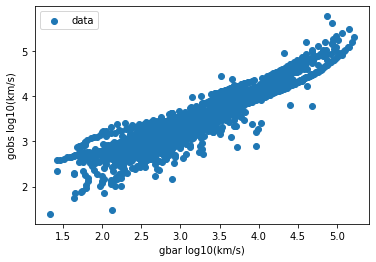

In [7]:
#Uncomment the two commented lines to get the Neros on there
#It doesn't really work, since it's per-galaxy rather than overall

vlum = np.array(all_vlum)
vObs = np.array(all_obs)
rad = np.array(all_rad)
vNeros = np.array(all_neros)
norm_vObs = np.array(norm_obs)
norm_vNeros = np.array(norm_neros)
residuals = vObs-vNeros

log_gbar = np.log10(vlum**2/rad)
log_gobs = np.log10(vObs**2/rad)
log_gneros = np.log10(vNeros**2/rad)

#ordered_for_plot = sorted(zip(log_gbar, log_gneros))

plt.scatter(log_gbar, log_gobs, label='data')
#plt.plot([x[0] for x in ordered_for_plot], [x[1] for x in ordered_for_plot], 'k-',label='Neros')
plt.xlabel('gbar log10(km/s)')
plt.ylabel('gobs log10(km/s)')
plt.legend()

In [8]:
outlier_inds = [i for i,v in enumerate(residuals) if abs(v) > 100]
outlier_gals = []
for ind in outlier_inds:
    outlier_gals.append(list(galaxies.keys())[gal[ind]])
    
print(set(outlier_gals))
with open(f'fit-analysis-plots/{MW_name}/outliers_{v1}_{v2}.txt', 'w+') as f:
    f.write('Galaxies with residuals greater than 200 (vNeros-vObs)\n')
    f.write(str(set(outlier_gals)))

{'UGC05253_rotmod-Copy1', 'NGC6674_rotmod-Copy1', 'UGC09133_rotmod-Copy1', 'UGC02953_rotmod-Copy1'}


In [9]:
# print(list(galaxies.keys())[gal[np.argmax(residuals)]])

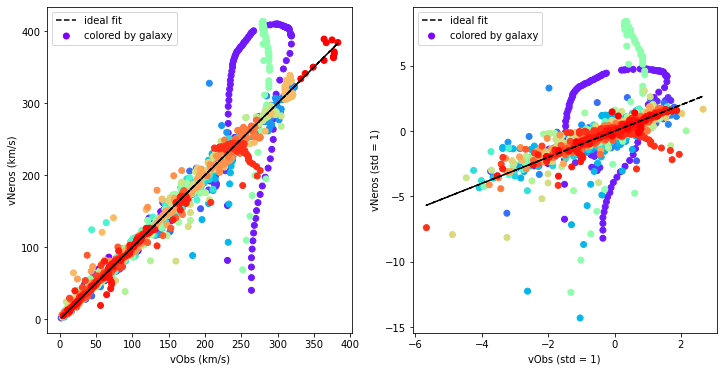

In [10]:
# Plots of vObs v. vNeros - a somewhat standard fitting plot
# The right plot is normalized in kind of a lazy way
f, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(all_obs, all_neros, c=gal, cmap='rainbow', label='colored by galaxy')
ax[0].set_xlabel('vObs (km/s)')
ax[0].set_ylabel('vNeros (km/s)')
ax[0].plot(all_obs, all_obs, 'k--', label='ideal fit')
ax[0].legend()
ax[1].scatter(norm_obs, norm_neros, c=gal, cmap='rainbow', label='colored by galaxy')
ax[1].set_xlabel('vObs (std = 1)')
ax[1].set_ylabel('vNeros (std = 1)')
ax[1].plot(norm_obs, norm_obs, 'k--', label='ideal fit')
ax[1].legend()
plt.savefig(f'fit-analysis-plots/{MW_name}/FitComparePlot_v1_{v1}_v2_{v2}.png')

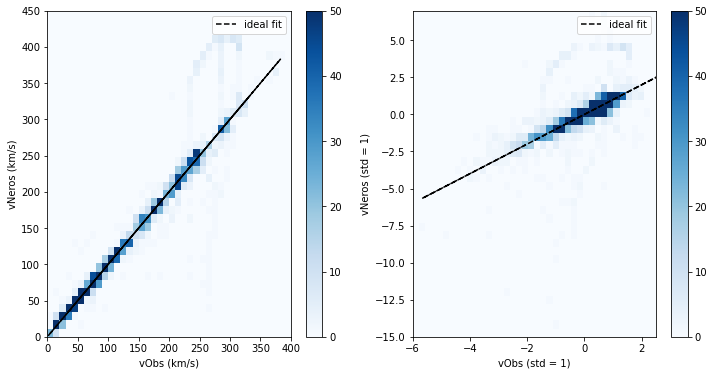

In [11]:
f, ax = plt.subplots(1,2, figsize=(12,6))
ax0plot = ax[0].hist2d(vObs, vNeros, range=[[0,400],[0,450]],bins=40, cmap='Blues', vmin=0, vmax=50)
plt.colorbar(ax0plot[3], ax=ax[0])
ax[0].set_xlabel('vObs (km/s)')
ax[0].set_ylabel('vNeros (km/s)')
ax[0].plot(all_obs, all_obs, 'k--', label='ideal fit')
ax[0].legend()
ax1plot = ax[1].hist2d(norm_vObs, norm_vNeros,range=[[-6,2.5],[-15,7]], bins=40, cmap='Blues',vmin=0, vmax=50)
plt.colorbar(ax1plot[3], ax=ax[1])
ax[1].set_xlabel('vObs (std = 1)')
ax[1].set_ylabel('vNeros (std = 1)')
ax[1].plot(norm_obs, norm_obs, 'k--', label='ideal fit')
ax[1].legend()
# ax[0].set_aspect(1)
# ax[1].set_aspect(0.45)

plt.savefig(f'fit-analysis-plots/{MW_name}/FitComparePlot_hist_v1_{v1}_v2_{v2}.png')

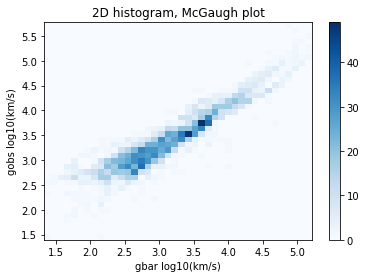

In [12]:
# Indirect assessment of model fits 
# comparing observed centripetal acceleration to luminous centripetal acceleration
# the luminous velocity is scaled by bulge, gas, and disk parameters from model fit.

plt.hist2d(log_gbar, log_gobs, bins=40, cmap='Blues')
plt.colorbar()
plt.xlabel("gbar log10(km/s)")
plt.ylabel("gobs log10(km/s)")
plt.title("2D histogram, McGaugh plot")
plt.savefig(f'fit-analysis-plots/{MW_name}/2dhistMcGaughPlot_v1_{v1}_v2_{v2}.png')

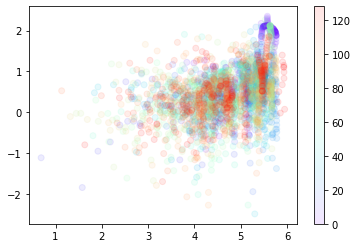

In [13]:
#attempt at McGaugh plot, not so good
plt.scatter(np.log(all_obs), np.log10(np.abs([x-y for x,y in zip(all_obs, all_neros)])), c=gal, cmap='rainbow', alpha=0.1)
plt.colorbar()

Text(0, 0.5, 'vNeros log(km/s)')

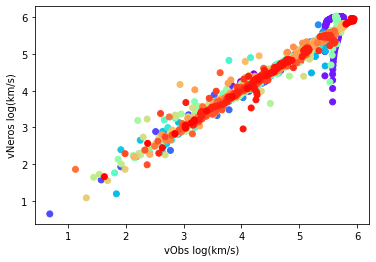

In [14]:
plt.scatter(np.log(all_obs), np.log(all_neros), c=gal, cmap='rainbow')
plt.xlabel('vObs log(km/s)')
plt.ylabel('vNeros log(km/s)')

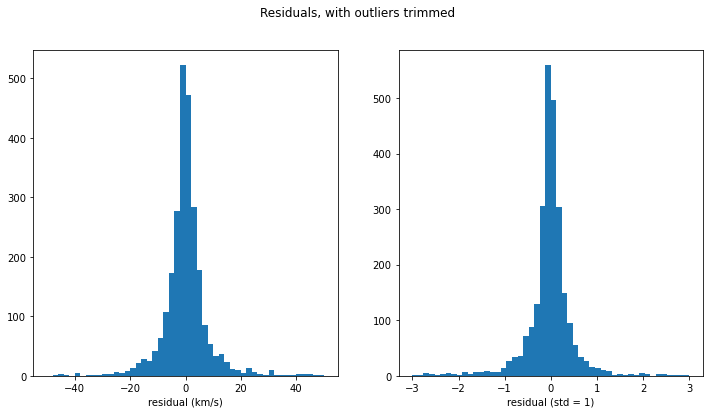

In [15]:
f, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist([x - y for x,y in zip(all_obs, all_neros)],bins=50, range=(-50,50))
ax[0].set_xlabel('residual (km/s)')
ax[1].hist([x-y for x,y in zip(norm_obs, norm_neros)],bins=50, range=(-3,3))
ax[1].set_xlabel('residual (std = 1)')
plt.suptitle('Residuals, with outliers trimmed')
plt.savefig(f'fit-analysis-plots/{MW_name}/ResidualHist_v1_{v1}_v2_{v2}.png')

## 7. Fitting residuals to a Gaussian distribution

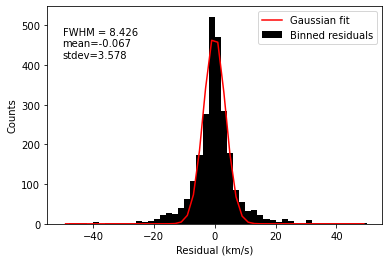

In [16]:
residuals = [x - y for x,y in zip(all_obs, all_neros)]
hist, bins, bars = plt.hist(residuals, bins=50, range=(-50,50))
bin_mid = [(bins[i] + bins[i-1])/2 for i in range(1,len(bins))]

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

init = [500, 0, 10]

fits, cov = curve_fit(gauss, bin_mid, hist, p0=init)
fitted_mean = fits[1]
fitted_std = fits[2]
FWHM = 2*np.sqrt(2*np.log(2))*fitted_std
plt.text(0-max(bins),max(hist)-max(hist)/5, 'FWHM = %.3f\nmean=%.3f\nstdev=%.3f'%(FWHM,fitted_mean,fitted_std))
plt.hist(residuals, bins=50, range=(-50,50), color="black", label='Binned residuals')
plt.plot(bin_mid, gauss(bin_mid, *fits), 'r-')
plt.xlabel('Residual (km/s)')
plt.ylabel('Counts') #raw count divided by the total number of counts and the bin width
plt.legend(['Gaussian fit','Binned residuals'])
plt.savefig(f'fit-analysis-plots/{MW_name}/ResidualHist_GaussFit_v1_{v1}_v2_{v2}.png')

## 8. Testing other fitting regimes

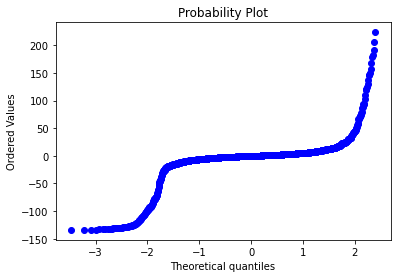

In [17]:
# Normal probability plot - should be linear if residuals are normally distributed
# results suggest heavy tails - too much data at extremes
fig = plt.figure()
ax = fig.add_subplot(111)
probplot([x - y for x,y in zip(all_obs, all_neros)], plot=ax)
plt.savefig(f'fit-analysis-plots/{MW_name}/Residual_normprobplot_v1_{v1}_v2_{v2}.png')